# Bol.com Forecasting business case

#### Imports

In [2]:
# Nothing needs to be changed here, just some importing of libraries

from typing import Optional, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
plt.rcParams["font.size"] = 14
plt.rcParams['figure.figsize'] = (16, 4.0)

from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error

In [3]:
# Nothing needs to be changed here, this loads the dataset

books = pd.read_csv('bol_books.csv')
books['date'] = pd.to_datetime(books.date)
books

,date,n
0,1998-11-01,13
1,1998-12-01,4
2,1999-01-01,31
3,1999-02-01,3
4,1999-03-01,246
...,...,...
273,2021-08-01,532662
274,2021-09-01,451951
275,2021-10-01,517288
276,2021-11-01,725337


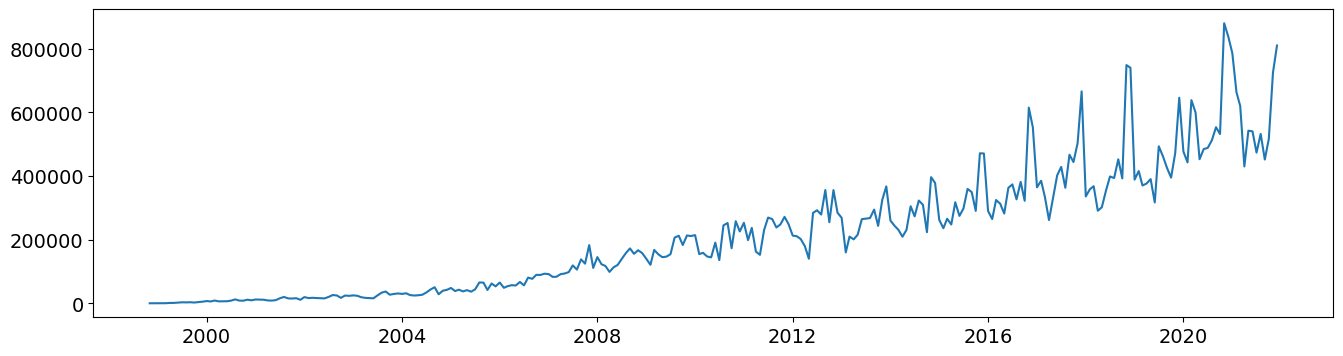

In [4]:
# Nothing needs to be changed here, this plots the dataset

plt.plot(books.date, books.n)

#### 1. Plot two centered rolling means with two different windows

> We want to see how well we can do without "Machine Learning". How well does it do if you just take the average sale of the past x months? Lets check it out here!

In [ ]:
# TODO: CREATE A ROLLING WINDOW OF THE PREVIOUS SALES OF THE lAST 10 MONTHS, THIS CAN BE A NICE INITIAL PREDICTOR (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html)
rolling_window_sales: List[float] = ...
# TODO: END CODEBLOCK

plt.plot(books.date, books.n, label='Actual sales')
plt.plot(books.date, rolling_window_sales, label='Rolling window sales')
plt.legend()
plt.show()

#### 2. Fit and plot a linear model. Does it adequately represent the trend?

> Now we are going to train our first Machine Learning model. We will keep it simple for now, and will use a simple linear regression model. A lot of the code has been written already for you, fill in the blanks and see how well a linear model performs.

In [ ]:
# Nothing needs to be changed here

def fit_and_plot_model(X: pd.DataFrame, y_true: pd.Series, dates: List, sklearn_model: BaseEstimator, pre_processor: Optional[ColumnTransformer] = None, X_train: Optional[pd.DataFrame] = None, y_train: Optional[pd.DataFrame] = None, X_test: Optional[pd.DataFrame] = None, y_test: Optional[pd.DataFrame] = None):
    """
    Helper method to fit / train a SKLearn model and to plot the results
    :param X: The features of the model, which is a pandas dataframe
    :param y_true: The target of the model, which is a pandas series that contains the monthly book sales
    :param dates: A list of dates that correspond to the monthly book sales, which length is equal to the length of y_true and the amount of rows in X.
    :param sklearn_model: The model which we want to train
    :param pre_processor: Optional, if we want to do some pre_processing on the features before we hand them to the model (SKlearn Column Transformer)
    :param X_train: Optional, if we want to split the dataset into a training dataset and testing dataset (later in the assignment)
    :param y_train: Optional, if we want to split the dataset into a training dataset and testing dataset (later in the assignment)
    :param X_test: Optional, if we want to split the dataset into a training dataset and testing dataset (later in the assignment)
    :param y_test: Optional, if we want to split the dataset into a training dataset and testing dataset (later in the assignment)
    :return:
    """
    pipeline_steps = [('model', sklearn_model)]
    if pre_processor:
        pipeline_steps.insert(0, ('preprocess', pre_processor))

    pipeline = Pipeline(pipeline_steps)

    if X_train is None or y_train is None or X_test is None or y_test is None:
        X_train = X
        y_train = y_true
        X_test = X
        y_test = y_true
    else:
        plt.axvline(x=dates[len(X_train)], label='Start of the test set', c='red')

    pipeline = pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    print(f"Mean absolute error is {round(mean_absolute_error(y_test, y_pred), 3)}")

    plt.plot(dates, y_true, label='Actual sales')
    plt.plot(dates, pipeline.predict(X), label='Predicted sales')
    plt.legend()
    plt.show()

In [ ]:
# TODO: DEFINE X AS A DATAFRAME WITH 1 COLUMN OF A NUMERIC SEQUENCE THAT INCREASES 1 BY 1 STARTING FROM 0. WE WILL USE THIS TO LET THE MODEL KNOW FOR WHAT DATE IT NEEDS TO PREDICT
# TODO: DEFINE Y AS THE TARGET (THE ACTUAL SALES NUMBERS). THIS IS THE TARGET THAT THE MODEL WILL TRY TO LEARN
X: pd.DataFrame = ...
y: List[int] = ...
# TODO: END CODEBLOCK

fit_and_plot_model(X=X, y_true=y, dates=books.date, sklearn_model=LinearRegression())

#### 3. Are there any noticeable break points? If so, add respective dummy(s) & interactions to the linear model.

> It could be that in 1 point of time the data starts to behave differently. This is what we call a breaking point. Do you see such a breaking point in the dataset? If so, fix it by filling in the blanks

In [ ]:
def get_features_with_breakpoint(df_books: pd.DataFrame, year: str) -> pd.DataFrame:
    # TODO: CREATE A NEW COLUMN WHICH IS TRUE IF BEFORE YEAR X (WHICH WILL BE YOUR BREAKING POINT) AND FALSE IF AFTER YEAR X
    df_books['before_year_x'] = ... (use the year variable here)
    # TODO: END CODEBLOCK

    return (
        df_books[['period_num', 'before_year_x']]
        .assign(interaction = lambda df: df.period_num*df.before_year_x)
    )
X_with_break = get_features_with_breakpoint(df_books=books, year=...)

fit_and_plot_model(X=X_with_break, y_true=y, dates=books.date, sklearn_model=LinearRegression())

#### 4. Add seasonal dummies to the model. How frequent should they be to capture seasonality well?

> Seasonality plays an important role in the field of Forecasting. Christmas trees are never bought in summer, whilst sunblocker is never bought during Christmas. Can you deal with seasonality here to improve the model?

In [ ]:
X_season = X_with_break

# TODO: CREATE A NEW COLUMN WHICH INDICATES SEASONALITY (THE YEAR / THE QUARTER / THE SEASON / THE MONTH), WHATEVER YOU LIKE
X_season['season'] = ...
# TODO: END CODEBLOCK

X_season['season'] = X_season['season'].astype(str)

feature_transformer = ColumnTransformer(
     [('numeric', 'passthrough', ['period_num', 'before_year_x', 'interaction']),
      ('categorical', OneHotEncoder(sparse=False, drop='first'), ['season'])]
)

fit_and_plot_model(X=X_season, y_true=y, dates=books.date, sklearn_model=LinearRegression(), pre_processor=feature_transformer)

#### 5. Use a better model to improve the predictive power

> So far we only used a simple linear model, but of course there are many more models which we can try out. Lets try a different one and lets see if the results change

In [ ]:
# TODO: FIND A BETTER MODEL ON THE SCIKIT LEARN WEBSITE AND TRY IT :-) (https://scikit-learn.org/stable/supervised_learning.html, tip: it is a regression problem)
better_model = ...
# TODO: END CODEBLOCK

fit_and_plot_model(X=X_season, y_true=y, dates=books.date, sklearn_model=better_model, pre_processor=feature_transformer)

#### 6. What will happen if we predict for the next year? Will it still perform well? Can you visualize this?

> So far we trained our model on the same data as we tested our model. If you ask Data Scientists, they will tell you that is an absolute no go. But why? Lets split the dataset in a training and testing dataset and see what happens.

In [ ]:
def create_train_test_split(X_to_split, y_to_split) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    # TODO: MAKE SURE WE HAVE A TRAIN TEST SPLIT OF THE DATASETS X_SEASON AND Y
    X_train, X_test = ..., ... (use X_to_split as the full X dataset)
    y_train, y_test = ..., ... (use y_to_split as the full y dataset)
    # TODO: END CODEBLOCK

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = create_train_test_split(X_season, y)

fit_and_plot_model(X=X_season, y_true=y, dates=books.date, sklearn_model=better_model, pre_processor=feature_transformer, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

#### 7. Can you think of other features to improve the model?

> This is the section where you can go nuts if you want. So far you only had to program small things in python to see the results, but now it is completely up to you. The model is not perfect by a long shot, lots of improvements are possible. So if you still have time, lets see how much improvement you can achieve. Good luck!

In [ ]:
X_improved = X_season
improved_model = better_model

# TODO: HERE YOU CAN DO ANYTHING TO MAKE THE MODEL BETTER. ADD FEATURES, CHANGE THE MODEL TO SOMETHING FANCY, WHATEVER YOU LIKE :)
...
...
...

# If you want to improve the features, make changes to X_improved

# If you want to change the model, make changes to improved_model

# If you want you can add features in here. If not, remove the "new feature 1" "new feature 2" strings from the array below
improved_feature_transformer = ColumnTransformer(
     [('numeric', 'passthrough', ['period_num', 'before_year_x', 'interaction', 'new feature 1', 'new feature 2']),
      ('categorical', OneHotEncoder(sparse=False, drop='first'), ['season'])]
)
# TODO: END CODEBLOCK

X_train, X_test, y_train, y_test = create_train_test_split(X_improved, y)

fit_and_plot_model(X=X_season, y_true=y, dates=books.date, sklearn_model=improved_model, pre_processor=improved_feature_transformer, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)